In [75]:
import urllib.request
import pandas as pd

In [143]:
# Read data
# see "satellite-data-download.ipynb" for how this data is obtained
df = pd.read_csv("../data/satellite_data.csv")
df.head()

,Name,Launch date (YYYY-MM-DD),Status,Action
0,STARLINK-3321,2022-01-06,IN ORBIT,TRACK IT
1,STARLINK-3323,2022-01-06,IN ORBIT,TRACK IT
2,STARLINK-3333,2022-01-06,IN ORBIT,TRACK IT
3,STARLINK-3335,2022-01-06,IN ORBIT,TRACK IT
4,STARLINK-3353,2022-01-06,IN ORBIT,TRACK IT


In [144]:
# Handle dates properly
df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1])
df.columns = ['Name', 'launch_date', 'Status', 'Action']
df.index = df.launch_date

In [145]:
# Make a note that the indexing happends at the end of each week as seen below
test = df[df["Name"].str.contains("IRIDIUM")].head()
print(test)
test.groupby([pd.Grouper(key='launch_date', freq='W-MON')])["Name"].count().reset_index()

                    Name launch_date    Status    Action
launch_date                                             
2019-01-11   IRIDIUM 180  2019-01-11  IN ORBIT  TRACK IT
2019-01-11   IRIDIUM 176  2019-01-11  IN ORBIT  TRACK IT
2019-01-11   IRIDIUM 168  2019-01-11  IN ORBIT  TRACK IT
2019-01-11   IRIDIUM 173  2019-01-11  IN ORBIT  TRACK IT
2019-01-11   IRIDIUM 169  2019-01-11  IN ORBIT  TRACK IT


,launch_date,Name
0,2019-01-14,5


In [264]:
# Get daily/weekly summation of launches
def get_counts(df, regex, negate=False):
    if negate:
        subset = df[~(df["Name"].str.contains(regex).values)]
    else:
        subset = df[(df["Name"].str.contains(regex).values)]
    subset = subset[subset["Status"] != "DECAYED"]
#     weekly = subset.groupby([pd.Grouper(key='launch_date', freq='W-MON')])["Name"].count().reset_index()
    counts = subset.groupby([pd.Grouper(key='launch_date', freq='D')])["Name"].count().reset_index()
    counts.columns = ["launch_date", "count"]
    counts["cumsum"] = counts["count"].cumsum()
    counts.index = counts.launch_date
    return counts

In [265]:
starlink = get_counts(df, "STARLINK")
oneweb = get_counts(df, "ONEWEB")
neither = get_counts(df, "STARLINK|ONEWEB|IRIDIUM", negate=True)
oneweb.head(5)

,launch_date,count,cumsum
launch_date,,,
2019-02-27,2019-02-27,6,6
2019-02-28,2019-02-28,0,6
2019-03-01,2019-03-01,0,6
2019-03-02,2019-03-02,0,6
2019-03-03,2019-03-03,0,6


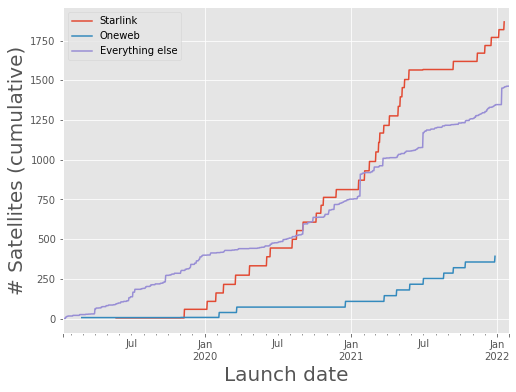

In [266]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
starlink["cumsum"].plot(figsize=(8,6), label="Starlink") 
oneweb["cumsum"].plot(label="Oneweb") 
neither["cumsum"].plot(label="Everything else") 
plt.ylabel("# Satellites (cumulative)", fontsize=20)
plt.xlabel("Launch date", fontsize=20)
plt.legend()

In [156]:
death = pd.read_csv("../data/state_centered.csv")
death.head()

,Unnamed: 0,State,flu_like_deaths,detrended,detrended_flu_like,median,median_flu_like,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week,centered,centered_flu_like,non_flu_deaths,detrended_non_flu_like,centered_non_flu_like
0,1,Alabama,38.0,1057.000000,38.0,1067.139241,33.5,2014-01-04,1057,2014-2019,1,-10.139241,4.5,1019.0,1019.000000,-14.639241
1,2,Alabama,37.0,1076.721519,37.0,1081.360759,35.0,2014-01-11,1077,2014-2019,2,-4.639241,2.0,1040.0,1039.721519,-6.639241
2,3,Alabama,34.0,1047.443038,34.0,1034.221519,32.5,2014-01-18,1048,2014-2019,3,13.221519,1.5,1014.0,1013.443038,11.721519
3,4,Alabama,42.0,1021.164557,42.0,1005.544304,23.0,2014-01-25,1022,2014-2019,4,15.620253,19.0,980.0,979.164557,-3.379747
4,5,Alabama,26.0,1039.886076,26.0,1056.265823,23.5,2014-02-01,1041,2014-2019,5,-16.379747,2.5,1015.0,1013.886076,-18.879747


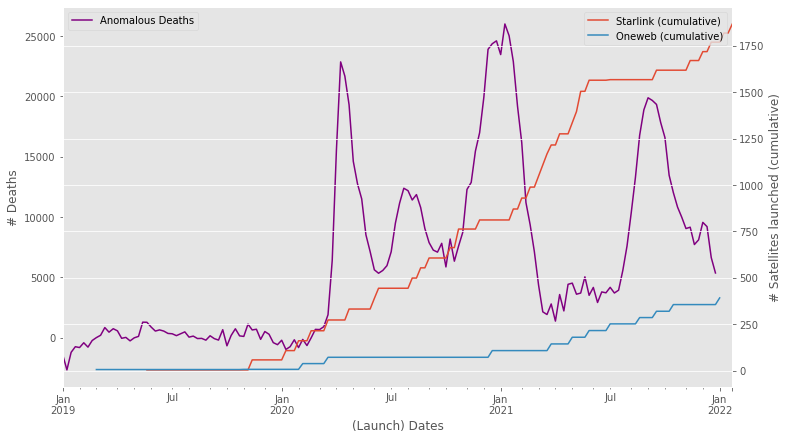

In [267]:
death.index = pd.to_datetime(death["Week.Ending.Date"])
us_death = death[(death.State == "United States") & (death.index.year >= 2019)]

# us_death["Total.Deaths"].plot(label="Deaths")
ax1 = us_death["centered"].plot(figsize=(12,7), label="Anomalous Deaths", color="purple")
# plt.legend(loc="upper left")
ax1.set_ylabel("# Deaths")

# ax2 = ax1.twinx()
# ax2.spines['right'].set_position(('axes', 1.0))
starlink["cumsum"].plot(ax=ax1, label="Starlink (cumulative)", secondary_y=True) 
oneweb["cumsum"].plot(ax=ax1, label="Oneweb (cumulative)", secondary_y=True) 
ax1.right_ax.set_ylabel("# Satellites launched (cumulative)")
first_legend = plt.legend(handles=[ax1.lines[0]], loc='upper left')
ax1.right_ax.set_xlabel("(Launch) Dates")
plt.gca().add_artist(first_legend)
plt.legend(handles=ax1.right_ax.lines, loc='upper right')
ax1.set_xlabel("(Launch) Dates")
plt.savefig("../figures/satellite_death.pdf")